In [1]:
%matplotlib inline

In [2]:
from pprint import pprint

import numpy as np
import tqdm
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("talk")

import sklearn as sk
import sklearn.svm

In [3]:
import utils
import visualization
import generate_features

## Feature generation
Load the data from the .mat files, generate the features, and save the resulting data to .csv files.  
For more implementation details have a look at **generate_features.py**

In [4]:
import importlib; importlib.reload(generate_features)
import importlib; importlib.reload(utils)
generate_features.main()

Loading data/raw_from_matlab/data2016.mat
('brushing', 'drinking', 'shoe', 'writing')
Saving data with features to data/processed/2016.csv
Loading data/raw_from_matlab/data2017.mat
('drinking', 'brushing', 'writing', 'shoe')
Saving data with features to data/processed/2017.csv
Loading data/raw_from_matlab/data2018.mat
('brushing', 'writing', 'drinking', 'shoelacing')
Saving data with features to data/processed/2018.csv
Saving full data with features to data/processed/all.csv


## Data Exploration

First load the data and inspect it.

In [5]:
#df = pd.read_csv('data/processed/2018.csv')
df = pd.concat((pd.read_csv(f'data/processed/{y}.csv') for y in (2016, 2017, 2018)))
_df18 = pd.read_csv(f'data/processed/2018.csv')
_df17 = pd.read_csv(f'data/processed/2017.csv')
_df16 = pd.read_csv(f'data/processed/2016.csv')

#df = pd.concat((_df18, _df17, _df16))
df = _df18
df['brushing'] = ['brushing' if l == 'brushing' else 'not brushing' for l in df.label]


print('Columns:')
print(df.columns)
print('Five random rows:')
print(df.sample(5))

Columns:
Index(['gx', 'gy', 'gz', 'std', 'skewness', 'f25', 'f75', 'label', 'gx_abs',
       'gy_abs', 'gz_abs', 'brushing'],
      dtype='object')
Five random rows:
           gx        gy        gz       std  skewness       f25        f75  \
12   0.287330  4.034274  8.047961  5.507914  1.147248  0.325240   8.817617   
46  -2.998696  2.892954  7.730359  0.492789  1.555796  0.635341   1.736598   
100 -6.828229 -0.449428  5.756639  0.609853  1.997309  4.497588  19.198657   
31   3.453372 -2.364310  6.963568  0.714760  0.523075  0.079355   1.626782   
47  -2.662954  2.578165  7.052974  0.514031  1.387221  0.767846   3.455309   

        label    gx_abs    gy_abs    gz_abs      brushing  
12   brushing  0.287330  4.034274  8.047961      brushing  
46   drinking  2.998696  2.892954  7.730359  not brushing  
100   writing  6.828229  0.449428  5.756639  not brushing  
31   drinking  3.453372  2.364310  6.963568  not brushing  
47   drinking  2.662954  2.578165  7.052974  not brushing  


Visualize pairs of features, using the [seaborn](https://seaborn.pydata.org/) function `pairplot`.

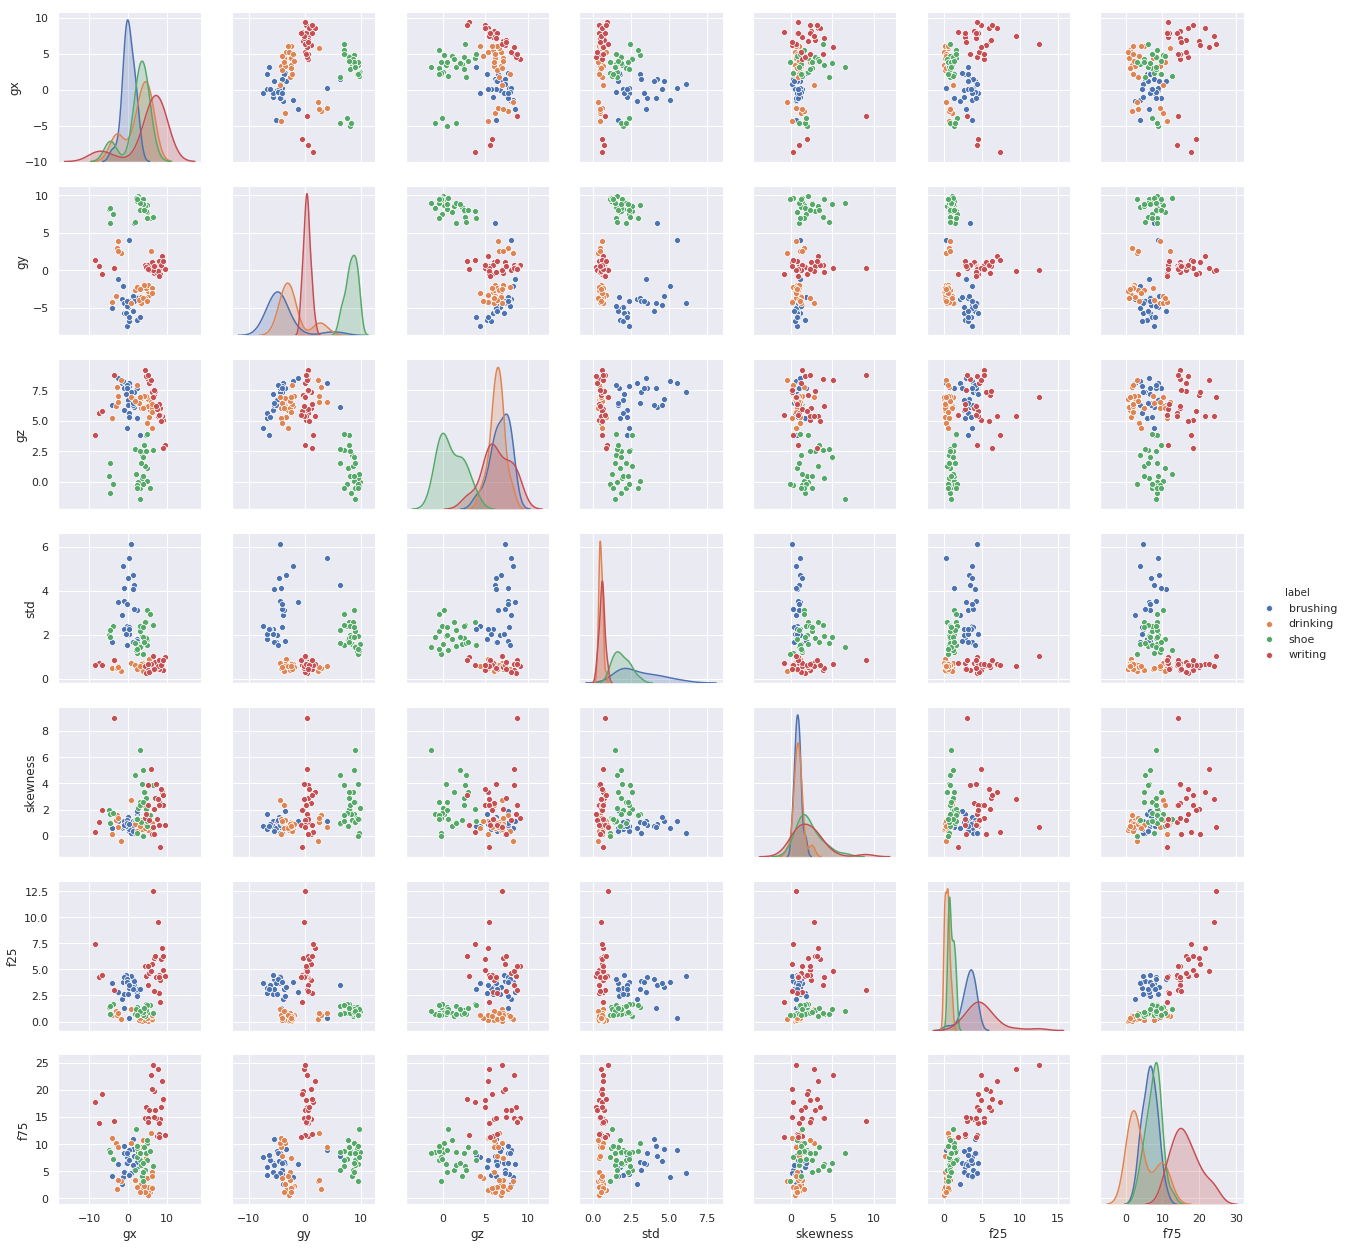

In [6]:
g = sns.pairplot(df.drop(['gx_abs', 'gy_abs', 'gz_abs'], axis=1), hue='label')
g.savefig('plots/first_pairplot.png', dpi=350)

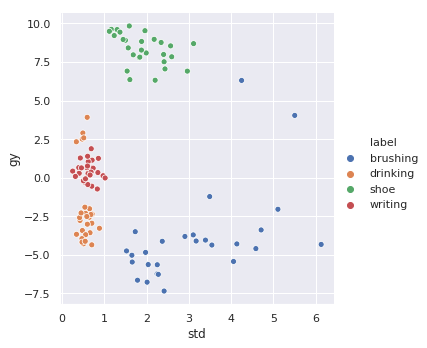

In [7]:
g = sns.relplot(x='std', y='gy', data=df, hue='label')
g.savefig('plots/first_pairplot_zoomed.png', dpi=350)
#sns.relplot(x='std', y='gy', data=_df16, hue='label')

## Train SVM
Fist create the necessary variables `X` and `y` and split them into train and test data.  

In [8]:
FEATURES_USED = ['std', 'gy']
SVM_PARAMETERS = {'kernel': 'linear'}
#FEATURES_USED = ['std', 'gy', 'gx', 'gz', 'skewness', 'f25', 'f75']
#SVM_PARAMETERS = {'kernel': 'poly'}

In [9]:
X = df[FEATURES_USED]
y = df.label == 'brushing'

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=1/3, random_state=0)

The actual training is done using [scikit-learn](https://scikit-learn.org/stable/).

In [10]:
clf = sk.svm.SVC(**SVM_PARAMETERS)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### Visualize the trained Classifier

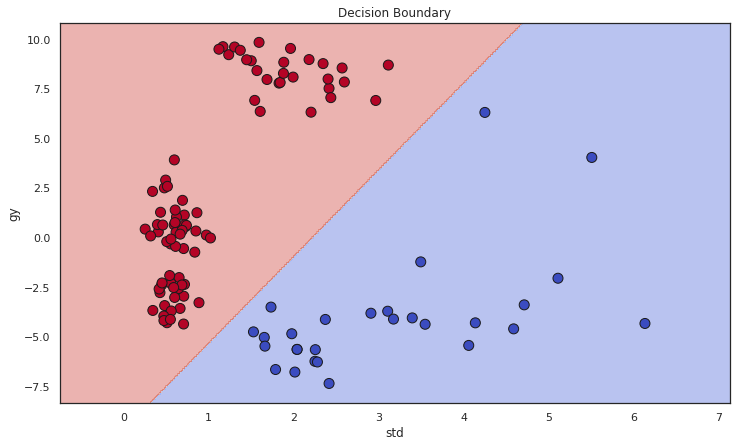

In [11]:
import importlib; importlib.reload(visualization)
if len(FEATURES_USED) == 2:
    sns.set_style('white')
    ax = visualization.plot_contours(X, y, clf)
    ax.set_title('Decision Boundary')
    ax.get_figure().savefig('plots/linear_decision_boundary.png')
    sns.set()

### ROC & ROC_AUC

Area under ROC curve: 1.0


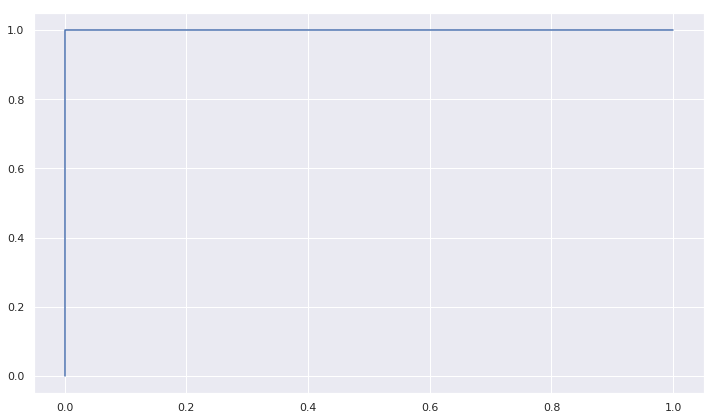

In [12]:
# ROC
visualization.plot_roc(X_test, y_test, clf)

# ROC-AUC
roc_auc = sk.metrics.roc_auc_score(y, clf.decision_function(X))
print('Area under ROC curve:', roc_auc)

### Confusion Matrix

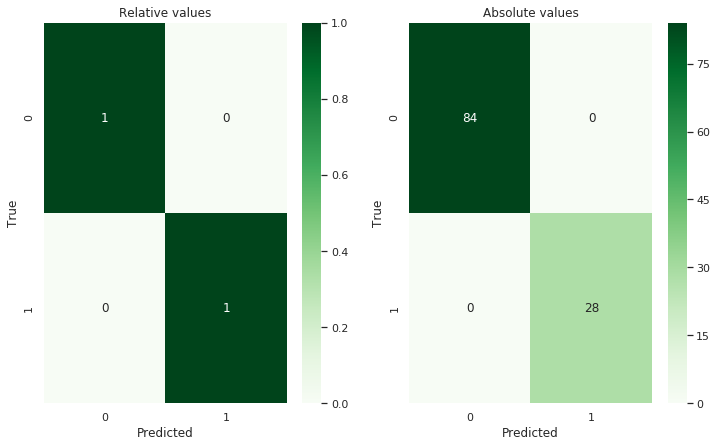

In [13]:
ax = visualization.plot_confusion_matrix(y, clf.predict(X))
ax.get_figure().savefig('plots/linear_model_confusion_matrix.png')

### Accuracy

In [14]:
print('2018 train metrics:')
visualization.print_metrics(y_train, clf.predict(X_train))
print('2018 test metrics:')
visualization.print_metrics(y_test, clf.predict(X_test))

2018 train metrics:
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0}
2018 test metrics:
{'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0}


## Detection on new data
The `testData.mat` file is structured differently to the files we trained on.

               x         y          z  label   activity
131697 -0.301205  1.108434   0.783133      0  undefined
94558  -0.361446  2.192771  -0.638554      0  undefined
35478   6.927711 -0.084337   6.566265      0  undefined
66236   1.746988  0.542169  10.554217      0  undefined
147127  7.867470 -0.530120   6.759036      0  undefined


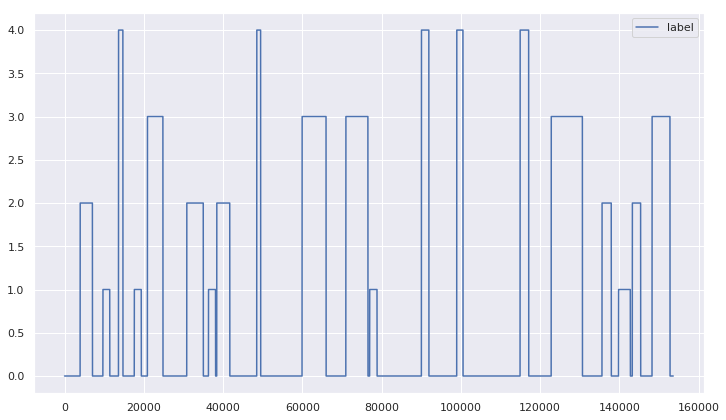

In [15]:
test_data = utils.load_testdata()
pprint(test_data.sample(5))
test_data.plot(y='label')

Make predictions on the `testData.mat` file. This consists of quite some steps, for more details look into `utils.py`.

In [16]:
import importlib; importlib.reload(utils)
y_predicted = utils.predict_on_streamed_data(clf, test_data, FEATURES_USED, window_size=20, window_step=2)

100%|█████████▉| 153483/153611 [01:37<00:00, 1622.50it/s]/home/nath/MEGA/Uni/ATHENS_2018_HealthInformatics/assignment/ATHENS2018/utils.py:216: RuntimeWarning: Mean of empty slice.
  final_prediction = bool(round(relevant_predictions.mean()))
/home/nath/MEGA/Uni/ATHENS_2018_HealthInformatics/assignment/ATHENS2018/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 153611/153611 [01:37<00:00, 1580.49it/s]


Present the predictions and the true values over time.

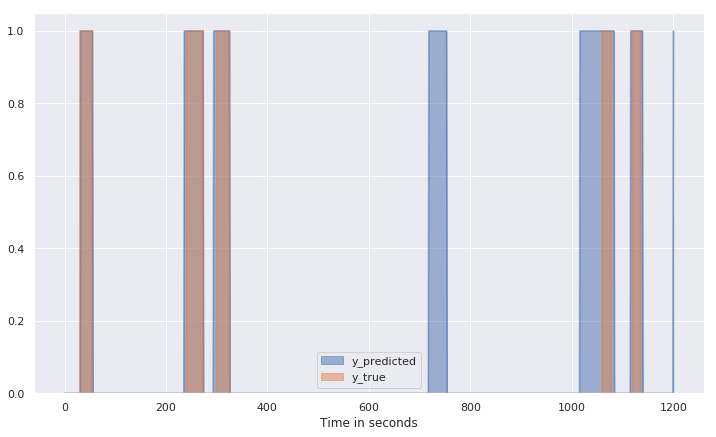

In [17]:
eval_df = pd.DataFrame({'y_predicted': y_predicted}, index=test_data.index)
eval_df['y_true'] = test_data['activity'] == 'brushing'
eval_df['seconds'] = eval_df.index / 128
ax = eval_df.astype(int).plot(
    x='seconds',
    y=['y_predicted', 'y_true'],
    kind='area',
    stacked=False,
    alpha=0.5)
ax.set_xlabel('')
ax.set_xlabel('Time in seconds')
ax.get_figure().savefig('plots/linear_testdata_prediction.png')

### Stats on testData.mat

Metrics:
{'Accuracy': 0.9104946911354005,
 'Precision': 0.5220037288493333,
 'Recall': 0.9892666666666666}


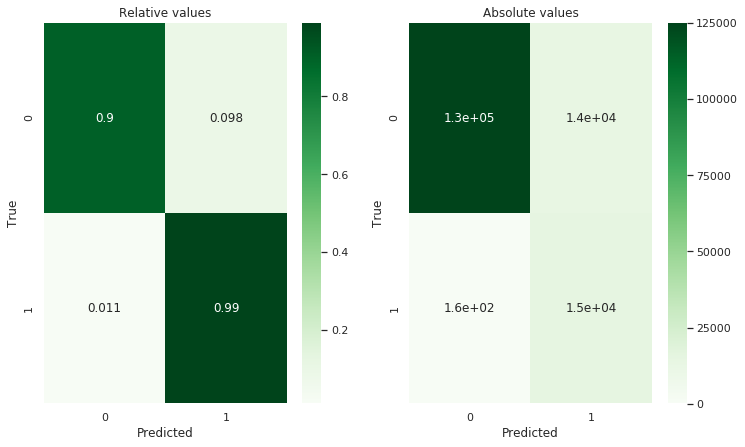

In [18]:
import importlib; importlib.reload(visualization)
# Confusion Matrix
ax = visualization.plot_confusion_matrix(eval_df.y_true, eval_df.y_predicted)
ax.get_figure().savefig('plots/backup_linear_confusionmatrix_testData.png')

# Metrics
metrics = {
    'Accuracy': sk.metrics.accuracy_score(eval_df.y_true, eval_df.y_predicted),
    'Precision': sk.metrics.precision_score(eval_df.y_true, eval_df.y_predicted),
    'Recall': sk.metrics.recall_score(eval_df.y_true, eval_df.y_predicted)
}
print('Metrics:')
pprint(metrics)

## Performance on 2016&2017 data

Metrics on the 2016 data:
{'Accuracy': 0.8, 'Precision': 0.6, 'Recall': 0.46153846153846156}
Metrics on the 2017 data:
{'Accuracy': 0.5, 'Precision': 0.0, 'Recall': 0.0}


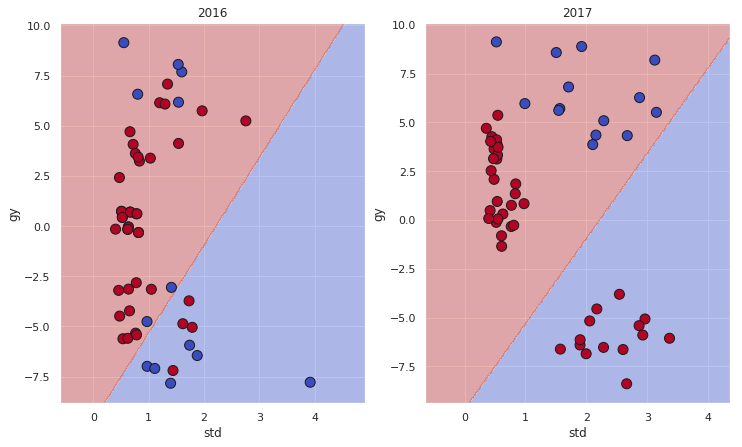

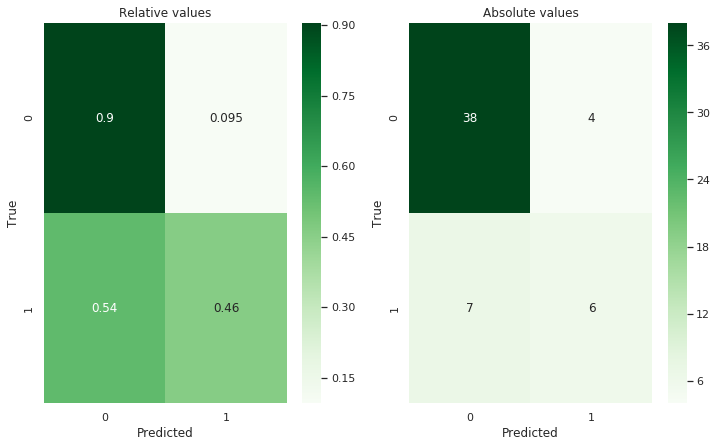

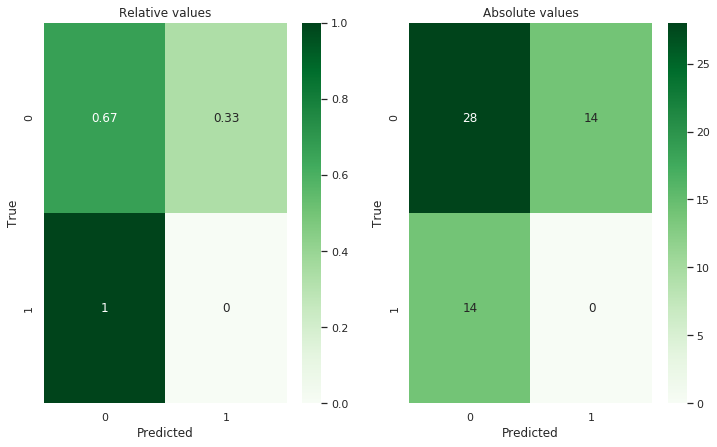

In [19]:
import importlib; importlib.reload(visualization)
visualization.results_on_years(clf, FEATURES_USED)

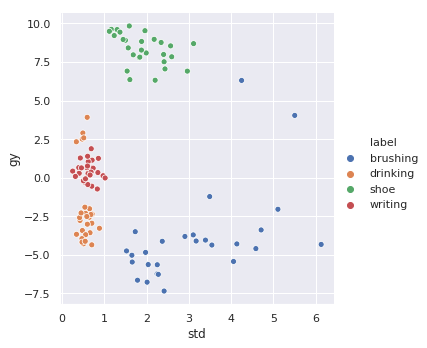

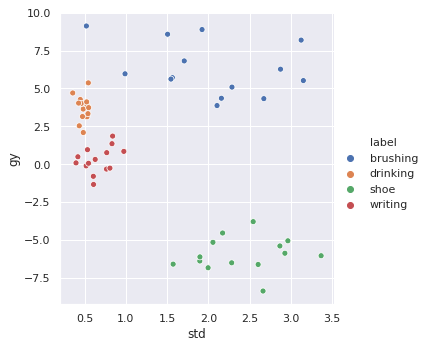

In [20]:
g = sns.relplot(x='std', y='gy', data=_df18, hue='label')
g = sns.relplot(x='std', y='gy', data=_df17, hue='label')

### Classifier trained on all 7 features

In [21]:
FEATURES_USED = ['std', 'gy', 'gx', 'gz', 'skewness', 'f25', 'f75', 'gy_abs', 'gx_abs', 'gz_abs']
#FEATURES_USED = ['std', 'gy', 'gx', 'gz', 'skewness', 'f25', 'f75']
SVM_PARAMETERS = {'kernel': 'poly'}

X = df[FEATURES_USED]
y = df.label == 'brushing'

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=1/3, random_state=0)
clf = sk.svm.SVC(**SVM_PARAMETERS)
clf.fit(X_train, y_train)

/home/nath/MEGA/Uni/ATHENS_2018_HealthInformatics/assignment/ATHENS2018/.venv/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Area under ROC curve: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        57
        True       1.00      1.00      1.00        17

   micro avg       1.00      1.00      1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74



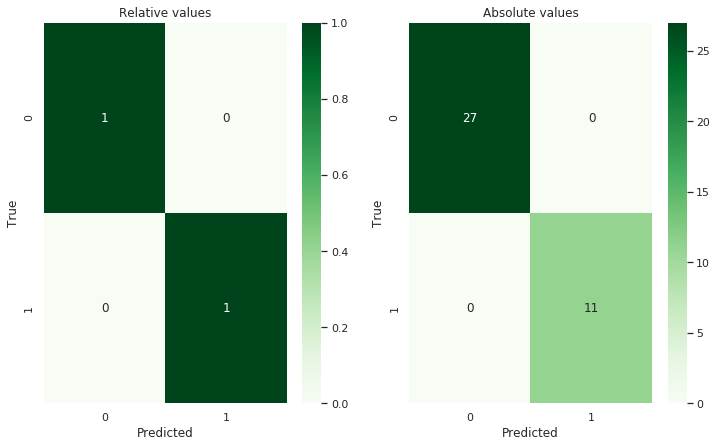

In [31]:
print('Area under ROC curve:', sk.metrics.roc_auc_score(y, clf.decision_function(X)))

print(sk.metrics.classification_report(y_train, clf.predict(X_train)))

ax = visualization.plot_confusion_matrix(y_test, clf.predict(X_test))

Metrics on the 2016 data:
{'Accuracy': 0.8909090909090909, 'Precision': 1.0, 'Recall': 0.5384615384615384}
Metrics on the 2017 data:
{'Accuracy': 0.8571428571428571,
 'Precision': 0.75,
 'Recall': 0.6428571428571429}


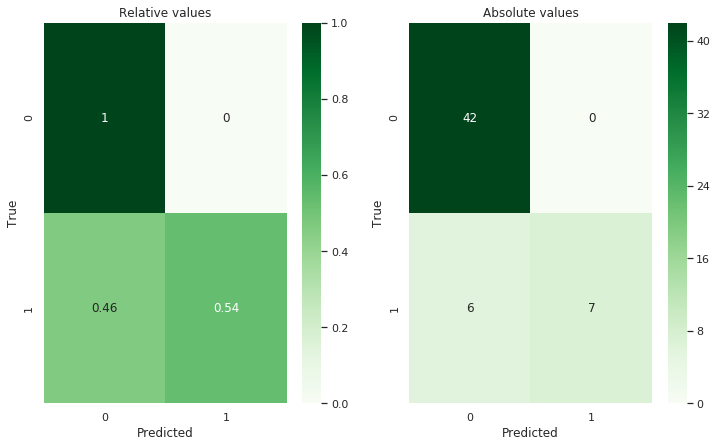

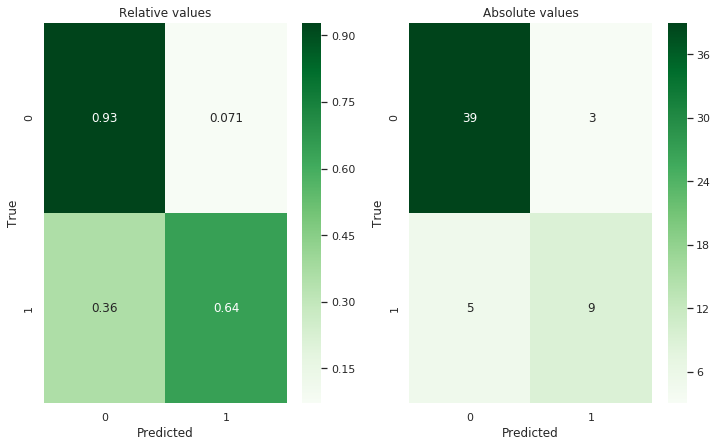

In [22]:
import importlib; importlib.reload(visualization)
visualization.results_on_years(clf, FEATURES_USED)

Evaluate on `testData.mat`

In [23]:
y_predicted = utils.predict_on_streamed_data(clf, test_data, FEATURES_USED, window_size=20, window_step=2)

100%|█████████▉| 153503/153611 [01:40<00:00, 1649.65it/s]/home/nath/MEGA/Uni/ATHENS_2018_HealthInformatics/assignment/ATHENS2018/utils.py:216: RuntimeWarning: Mean of empty slice.
  final_prediction = bool(round(relevant_predictions.mean()))
/home/nath/MEGA/Uni/ATHENS_2018_HealthInformatics/assignment/ATHENS2018/.venv/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 153611/153611 [01:40<00:00, 1524.14it/s]


{'Accuracy': 0.9719356035700568,
 'Precision': 0.8311543466137927,
 'Recall': 0.8942666666666667}


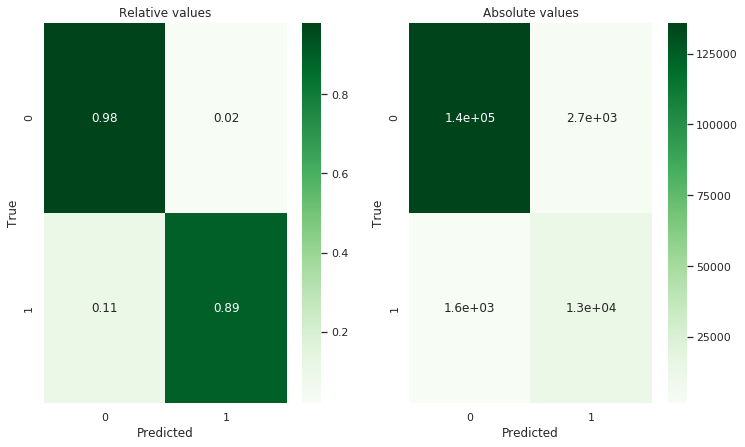

In [24]:
eval_df = pd.DataFrame({'y_predicted': y_predicted}, index=test_data.index)
eval_df['y_true'] = test_data['activity'] == 'brushing'

import importlib; importlib.reload(visualization)
# Confusion Matrix
visualization.plot_confusion_matrix(eval_df.y_true, eval_df.y_predicted)

# Metrics
visualization.print_metrics(eval_df.y_true, eval_df.y_predicted)

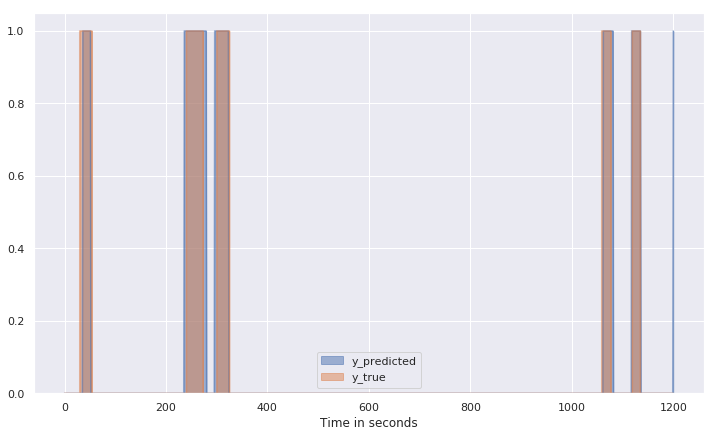

In [25]:
eval_df = pd.DataFrame({'y_predicted': y_predicted}, index=test_data.index)
eval_df['y_true'] = test_data['activity'] == 'brushing'
eval_df['seconds'] = eval_df.index / 128
ax = eval_df.astype(int).plot(
    x='seconds',
    y=['y_predicted', 'y_true'],
    kind='area',
    stacked=False,
    alpha=0.5)
ax.set_xlabel('Time in seconds')
ax.get_figure().savefig('plots/full_testdata_prediction.png')